# KdV equation with adaptive sampling measure

In [5]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *
from Error import *
from JaxUtils import *

### Setup

In [6]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [7]:
problem_data = ProblemData(name='kdv_adaptive', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=6, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           N=2048, # number of spatial points
                           dt=0.001, # time step
                          )

training_data = TrainingData(m=5, # number of neurons per layer
                             batch_size=10000, # batch size
                             epochs=100000, # number of epochs
                             gamma=0.1, # learning rate
                             scheduler=optax.linear_schedule(init_value=0.1, end_value=0.01, 
                                                             transition_steps=1000, transition_begin=1000) # learning rate scheduler
                            )

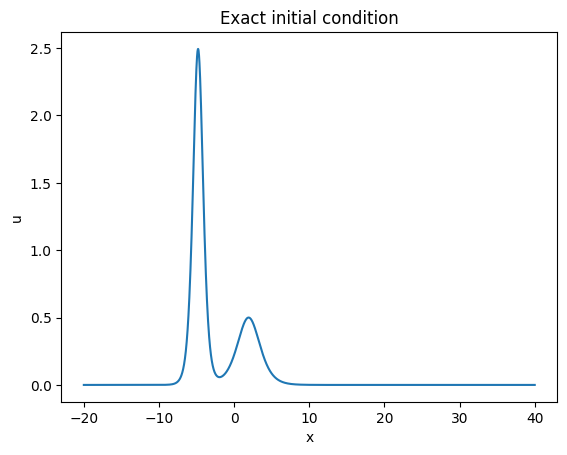

In [8]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [9]:
print(problem_data)

Problem data:
  name: kdv_adaptive, d: 1, domain: (-20, 40), T: 6, N: 2048, dt: 0.001


In [10]:
print(training_data)

Training data:
  m: 5, batch size: 10000, epochs: 100000, gamma: 0.1, seed: 0, scheduler: <function polynomial_schedule.<locals>.schedule at 0x7f8a6052a200>


### Initial fit

In [11]:
# Neural network

net = DeepNetKdV(training_data.m)
print(net)

DeepNetKdV(
    # attributes
    m = 5
)


In [12]:
# Initial fit

initial_fit = False

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name +'.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '.npy', allow_pickle=True).item()

### Time evolution

In [39]:
theta_flat, unravel = jax.flatten_util.ravel_pytree(theta) # flatten a pytree of arrays down to a 1D array
u_fn = unraveler(net.apply, unravel) # auxiliary function that allows to evaluate the NN starting from the flattened parameters

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    assert(len(x.shape) == 2)
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x

In [115]:
# TODO: is there a way to put these functions in a separate file?

@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix (with boundary correction).
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    
    zeta = 10000
    x_lower, x_upper = jnp.array(problem_data.domain[0]).reshape(-1, 1), jnp.array(problem_data.domain[1]).reshape(-1, 1)
    u_dth_lower, u_dth_upper = U_dtheta(theta_flat, x_lower), U_dtheta(theta_flat, x_upper)
    u_dth_mean = jnp.mean(u_dth, axis=0).reshape(-1, 1)
    B_lower, B_upper = u_dth_lower * u_dth_mean, u_dth_upper * u_dth_mean
    B = zeta * (B_lower + B_upper)
    return M + B


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    assert(len(x.shape) == 2)
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F


@jax.jit
def r_fn(theta_flat, delta_theta_flat, x, t):
    '''
    Compute the local-in-time residual (with boundary correction).
    '''
    zeta = 10000
    x_lower, x_upper = jnp.array(problem_data.domain[0]).reshape(-1, 1), jnp.array(problem_data.domain[1]).reshape(-1, 1) 
    if len(x.shape) == 0 or len(x.shape) == 1:
        # r = jnp.dot(U_dtheta(theta_flat, x.reshape(-1, 1)), delta_theta_flat) - rhs(theta_flat, x.reshape(-1, 1), t)
        r = jnp.dot((U_dtheta(theta_flat, x.reshape(-1, 1)) + zeta * (U_dtheta(theta_flat, x_lower) + U_dtheta(theta_flat, x_upper))), delta_theta_flat) - \
                rhs(theta_flat, x.reshape(-1, 1), t)
        return r.squeeze()
    return jnp.dot((U_dtheta(theta_flat, x) + zeta * (U_dtheta(theta_flat, x_lower) + U_dtheta(theta_flat, x_upper))), delta_theta_flat) - rhs(theta_flat, x, t)

In [15]:
# AR method for the initial sampling from u

from scipy.stats import norm, uniform

def initial_sampling(f, n, max_it=1000):

    x = []
    C = 29
    g = norm(loc=-5, scale=4.5)

    for i in range(n):
        it = 0
        while it < max_it:
            y = g.rvs() # sample from the Gaussian
            u = uniform.rvs() # sample from a uniform in [0, 1]
            if u <= f(y) / (C * g.pdf(y)):
                x.append(y)
                break
            it += 1
        if it >= max_it:
            raise Exception("AR did not converge.")

    return jnp.array(x)


def KdVWrapper(x):
        x = jnp.array([x])
        kdv = exactKdVTwoSol(x, 0)
        return kdv.squeeze()

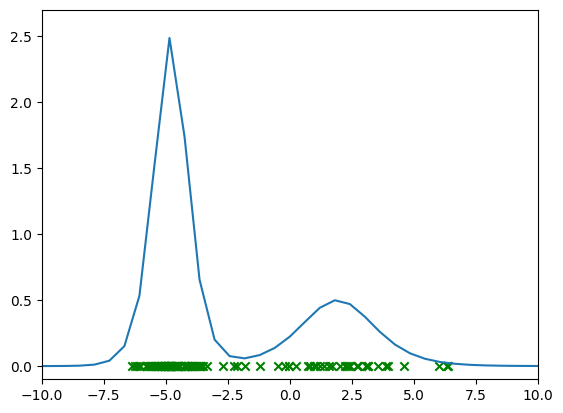

In [16]:
n = 100
x_test = initial_sampling(KdVWrapper, n)

x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], n)
plt.scatter(x_test, jnp.zeros(n), c='green', marker='x')
plt.plot(x_plot, exactKdVTwoSol(x_plot, 0))
plt.xlim([-10, 10])
plt.ylim([-0.1, 2.7])
plt.show()

In [30]:
@jax.jit
def SVGD_kernel(theta, h):
    '''
    Function adapted from: https://github.com/dilinwang820/Stein-Variational-Gradient-Descent/blob/master/python/svgd.py
    '''
    # sq_dist = pdist(theta)
    # pairwise_dists = squareform(sq_dist) ** 2
    theta_norm_squared = jnp.sum(theta ** 2, axis=1, keepdims=True)
    pairwise_dists = theta_norm_squared + theta_norm_squared.T - 2 * jnp.dot(theta, theta.T)
    # if h < 0: # median trick
    #     h = jnp.median(pairwise_dists)  
    #     h = jnp.sqrt(0.5 * h / jnp.log(theta.shape[0] + 1))

    # compute the rbf kernel
    Kxy = jnp.exp(- pairwise_dists / h ** 2 / 2)

    dxkxy = - jnp.matmul(Kxy, theta)
    sumkxy = jnp.sum(Kxy, axis=1)
    # for i in range(theta.shape[1]):
    #     dxkxy = dxkxy.at[:, i].set(dxkxy[:, i] + jnp.multiply(theta[:, i], sumkxy))
    dxkxy += jnp.multiply(theta, jnp.expand_dims(sumkxy, axis=1)) # vectorized
    dxkxy /= (h ** 2)
    return (Kxy, dxkxy)


def SVGD_update(x0, lnprob, n_iter=1000, stepsize=1e-3, alpha=1.0, debug=False):
    '''
    Function adapted from: https://github.com/dilinwang820/Stein-Variational-Gradient-Descent/blob/master/python/svgd.py
    '''
    # check input
    if x0 is None or lnprob is None:
        raise ValueError('x0 or lnprob cannot be None!')
    
    theta = jnp.copy(x0) 

    for iter in range(n_iter):
        if debug and (iter + 1) % 1000 == 0:
            print('iter', str(iter + 1))

        lnpgrad = lnprob(theta.squeeze()).reshape(-1, 1) # lnpgrad: (n, d)
        # calculating the kernel matrix
        kxy, dxkxy = SVGD_kernel(theta, h=0.05) # kxy: (n, n), dxkxy: (n, d)
        grad_theta = alpha * (jnp.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0] # grad_theta: (n, d)
        
        # vanilla update
        theta = theta + stepsize * grad_theta
        
    return theta

iter 1000
iter 2000
iter 3000
iter 4000
iter 5000
iter 6000
iter 7000
iter 8000
iter 9000
iter 10000


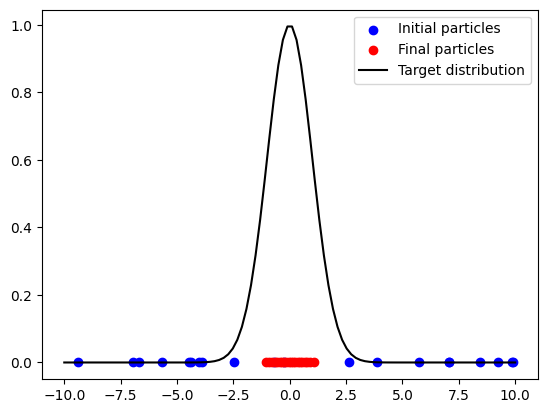

In [18]:
# Test SVGD against a simple Gaussian

@jax.jit
def gaussian(x, mu, sigma):
    return jnp.exp(- 0.5 * (x - mu) ** 2 / sigma ** 2)

@jax.jit
def log_gaussian(x, mu, sigma):
    return jnp.log(gaussian(x, mu, sigma))

@jax.jit
def log_gaussian_dx(x, mu, sigma):
    return jax.vmap(jax.grad(log_gaussian), (0, None, None))(x, mu, sigma)

def test_SVGD():
    
	# Initial particles
    x0 = jax.random.uniform(jax.random.key(0), shape=(20, ), minval=-10, maxval=10).reshape(-1, 1)
    
    dlnprob = lambda x: log_gaussian_dx(x, 0, 1)

    theta = SVGD_update(x0, dlnprob, n_iter=10000, stepsize=0.05, debug=True)

    # Plot
    plt.scatter(x0, jnp.zeros_like(x0), color='blue', label='Initial particles')
    plt.scatter(theta, jnp.zeros_like(theta), color='red', label='Final particles')
    x_plot = jnp.linspace(-10, 10, 100)
    plt.plot(x_plot, gaussian(x_plot, 0, 1), color='black', label='Target distribution')
    plt.legend()
    plt.show()


test_SVGD()

In [60]:
# @jax.jit
def predictor_corrector(theta_flat, x, t, dt, M_fn, F_fn):
    '''
    Predictor-corrector scheme based on forward Euler.
    '''
    M = M_fn(theta_flat, x)
    F = F_fn(theta_flat, x, t)
    theta_flat_pred = theta_flat + dt * jnp.linalg.lstsq(M, F)[0]
    return theta_flat_pred


# sigma = 0.05 # bandwidth

# @jax.jit
# def gaussian_kernel(x1, x2):
#     # return jnp.exp(- jnp.abs(x1 - x2) ** 2 / (2 * sigma ** 2))
#     return jnp.exp(- jnp.abs(x1[:, jnp.newaxis] - x2) ** 2 / (2 * sigma ** 2))

# @jax.jit
# def gaussian_kernel_dx(x1, x2):
#     # return - (x1 - x2) * gaussian_kernel(x1, x2) / sigma ** 2
#     return - (x1[:, jnp.newaxis] - x2) * gaussian_kernel(x1, x2) / sigma ** 2


def adaptive_sampling(theta_flat, problem_data, n, x, t, M_fn, F_fn, r_fn):
    '''
    Adaptive sampling with SVGD.
    '''
    alpha = 1.0 # scaling parameter... WHICH VALUE?
    gamma = 0.25 # tempering parameter
    epsilon = 0.05 # step size
    steps = 500

    # Predictor-corrector scheme
    theta_flat_pred = predictor_corrector(theta_flat, x, t, problem_data.dt, M_fn, F_fn)

    # The target measure is proportional to the residual scaled by a tempering parameter
    mu = lambda y: jnp.abs(r_fn(theta_flat, theta_flat_pred - theta_flat, y, t)) ** (2 * gamma)
    log_mu = lambda y: jnp.log(mu(y)) # log(mu) = - V
    log_mu_dx = jax.vmap(jax.grad(log_mu), 0)

    # Gaussian kernel
    # sigma = 0.05 # bandwidth
    # gaussian_kernel = lambda x1, x2: jnp.exp(- jnp.abs(x1 - x2) ** 2 / (2 * sigma ** 2))
    # gaussian_kernel_dx = lambda x1, x2: - (x1 - x2) * kernel(x1, x2) / sigma ** 2

    # print('Running SVGD...')

    # for s in range(steps):
    #     # if s % 10 == 0:
    #     #     print(f'  s = {s}/{steps}')
    #     # phi = lambda y: alpha * jnp.mean(gaussian_kernel(x, y) * log_mu_dx(x) + gaussian_kernel_dx(x, y))
    #     # x = x + epsilon * jnp.array([phi(x_i) for x_i in x]).reshape(-1, 1)
    #     phi = lambda y: alpha * jnp.mean(gaussian_kernel(x, y) * log_mu_dx(x) + gaussian_kernel_dx(x, y), axis=1)
    #     x = x + epsilon * phi(x)

    x = SVGD_update(x, log_mu_dx, n_iter=steps, stepsize=epsilon, alpha=alpha)

    return x

In [121]:
def runge_kutta_scheme(theta_flat, problem_data, n, M_fn, F_fn):

    # Sample points in the spatial domain
    x = initial_sampling(KdVWrapper, n).reshape(-1, 1)
        
    def rhs_RK45(t, theta_flat):
        return jnp.linalg.lstsq(M_fn(theta_flat, x), F_fn(theta_flat, x, t))[0]

    # Points for plotting and error evaluation
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    
    solution = []
    timesteps = []
    
    scheme = scipy.integrate.RK45(rhs_RK45, 0, theta_flat, problem_data.T, max_step=1e-2) # should be constant step 1e-4!

    temp_index = 0

    while scheme.t < problem_data.T:

        print(f'  t = {scheme.t:.5f}')

        # Sample points in the spatial domain
        x = adaptive_sampling(theta_flat, problem_data, n, x, scheme.t, M_fn, F_fn, r_fn)
        
        # Integration step
        scheme.step()
        timesteps.append(scheme.t)

        # Save current solution
        u = U(scheme.y, x_plot.reshape(-1, 1))
        solution.append(u)

        if temp_index % 10 == 0:
            plt.scatter(x, jnp.zeros(n), c='green', marker='x')
            plt.plot(x_plot, exactKdVTwoSol(x_plot, scheme.t))
            plt.plot(x_plot, U(scheme.y, x_plot.reshape(-1, 1)))
            plt.xlim([-20, 40])
            plt.ylim([-0.5, 2.7])
            plt.show()

        temp_index += 1
        
    return solution, timesteps

In [114]:
def neural_galerkin(theta_flat, problem_data, n, sampler, scheme):

    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N) # points for plotting and error evaluation

    solution = []

    print('Run time evolution...')

    # Initialize the particles by sampling from the initial condition
    # if sampler == 'svgd':
        # x = initial_sampling(KdVWrapper, n).reshape(-1, 1)
        # x = jax.random.uniform(jax.random.key(0), (n, problem_data.d), minval=problem_data.domain[0], maxval=problem_data.domain[1])

    solution, timesteps = runge_kutta_scheme(theta_flat, problem_data, n, M_fn, F_fn)

    # t = 0
    # while t < problem_data.T:

    #     if int(t / problem_data.dt) % 20 == 0:
    #         print(f'  t = {t:.2f}/{problem_data.T:.2f}')
    #         plt.scatter(x, jnp.zeros(n), c='green', marker='x')
    #         plt.plot(x_plot, exactKdVTwoSol(x_plot, t))
    #         plt.plot(x_plot, U(theta_flat, x_plot.reshape(-1, 1)))
    #         plt.xlim([-10, 10])
    #         plt.ylim([-0.1, 2.7])
    #         plt.show()

    #     # Save current solution
    #     u = U(theta_flat, x_plot.reshape(-1, 1))
    #     solution.append(u)

    #     # Sample points in the spatial domain
    #     if sampler == 'unif':
    #         seed = int(t * 1e6)
    #         x = jax.random.uniform(jax.random.key(seed), (n, problem_data.d), minval=problem_data.domain[0], maxval=problem_data.domain[1])
    #     elif sampler == 'svgd':
    #         x = adaptive_sampling(theta_flat, problem_data, n, x, t, M_fn, F_fn, r_fn)
    #     else:
    #         print('Sampling strategy not implemented yet.')
    #         raise NotImplementedError

    #     if scheme == 'rk45':
    #         theta_flat = runge_kutta_scheme(theta_flat, x, t, problem_data.dt, M_fn, F_fn)
    #     else:
    #         print('ODE solver not implemented yet.')
    #         raise NotImplementedError

    #     t = t + problem_data.dt

    return solution, timesteps

Run time evolution...
  t = 0.00000


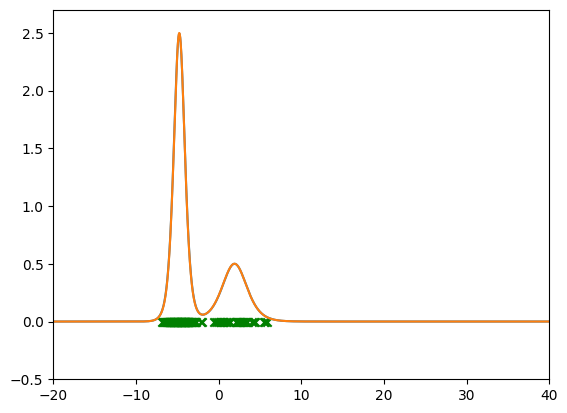

  t = 0.01000
  t = 0.02000
  t = 0.03000
  t = 0.04000
  t = 0.05000
  t = 0.06000
  t = 0.07000
  t = 0.08000
  t = 0.09000
  t = 0.10000


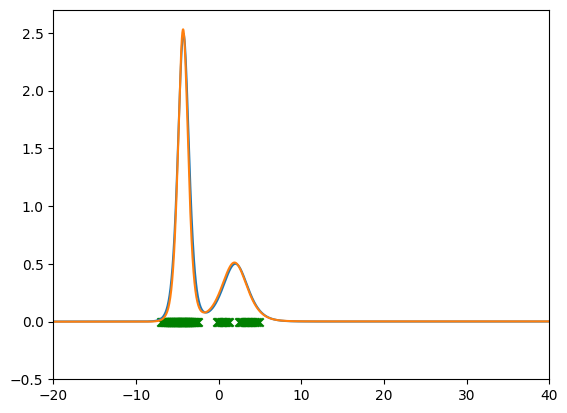

  t = 0.11000
  t = 0.12000
  t = 0.13000
  t = 0.14000
  t = 0.15000
  t = 0.16000
  t = 0.17000
  t = 0.18000
  t = 0.19000
  t = 0.20000


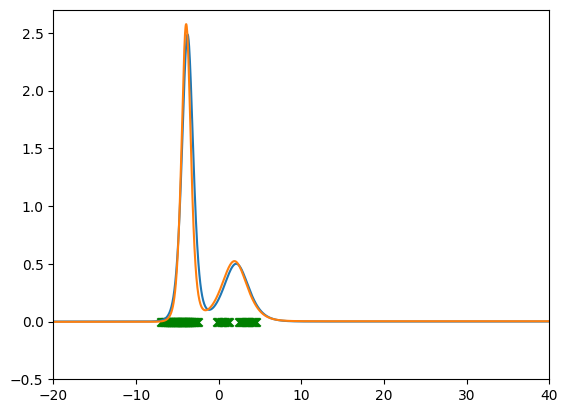

  t = 0.21000
  t = 0.22000
  t = 0.23000
  t = 0.24000
  t = 0.25000
  t = 0.26000
  t = 0.27000
  t = 0.28000
  t = 0.29000
  t = 0.30000


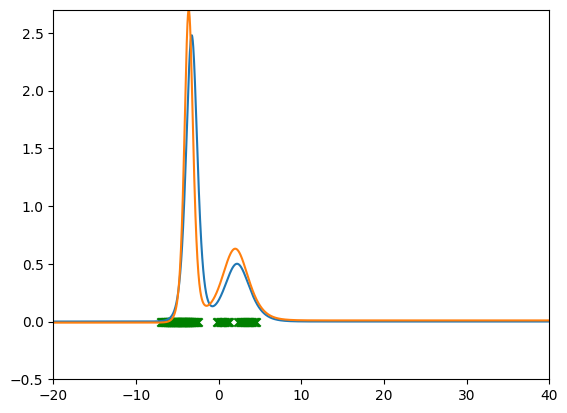

  t = 0.31000
  t = 0.32000
  t = 0.33000
  t = 0.34000
  t = 0.35000
  t = 0.36000
  t = 0.37000
  t = 0.38000
  t = 0.39000
  t = 0.40000


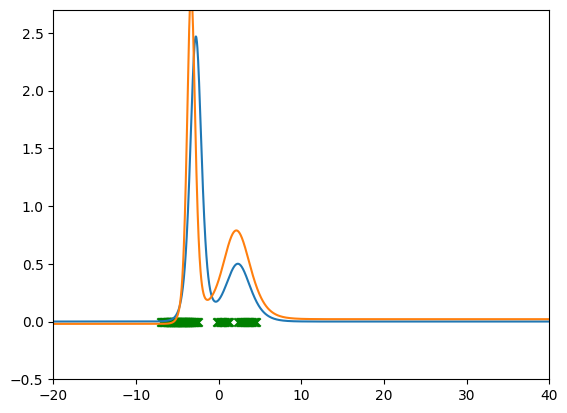

  t = 0.41000
  t = 0.42000
  t = 0.43000
  t = 0.44000
  t = 0.45000
  t = 0.46000
  t = 0.47000
  t = 0.48000
  t = 0.49000
  t = 0.50000


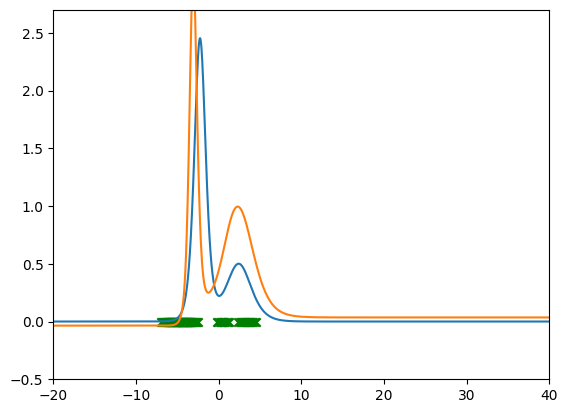

  t = 0.51000
  t = 0.52000
  t = 0.53000


KeyboardInterrupt: 

In [122]:
solution, timesteps = neural_galerkin(theta_flat=theta_flat, # parameters
                           problem_data=problem_data, # problem data
                           n=100, # sample points
                           sampler='svgd', # sampling strategy
                           scheme='rk45' # ODE solver
                          )

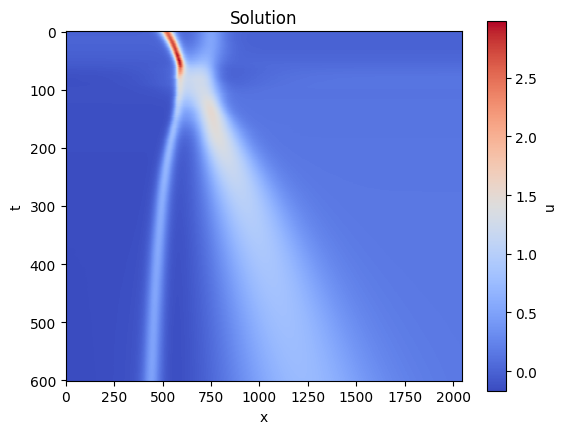

In [22]:
plot_solution(solution)

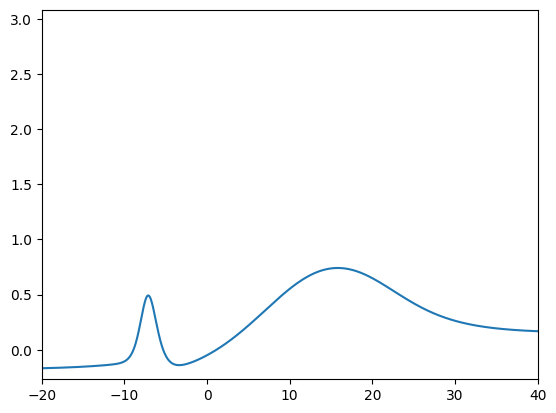

In [23]:
plot_animation(solution, problem_data)

### Compute relative error

In [24]:
errors = compute_error(solution, exactKdVTwoSol, problem_data)

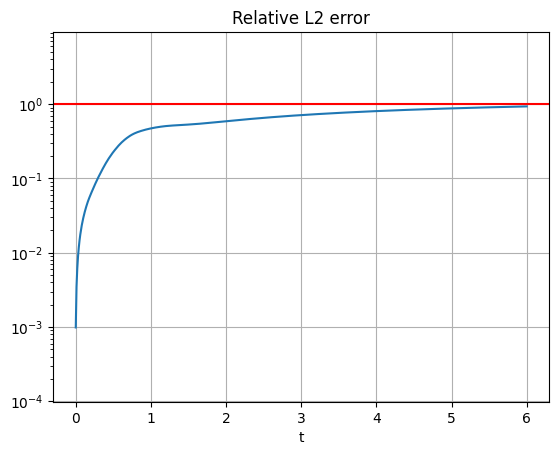

In [25]:
plot_error(errors, problem_data, 'Relative L2 error')